<a href="https://colab.research.google.com/github/shuuuuyu/114-1-Programing-Language/blob/main/hw_2_%E6%88%90%E7%B8%BE%E4%B8%80%E6%9C%AC%E9%80%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 成績管理系統 - 使用說明

## 簡介
整合 **Google Sheets + Gemini AI** 的智慧成績管理系統,提供成績計算、AI 作答分析、統計報告三大功能。

## **API Key 設定**
程式碼中使用的 API Key 名稱為: `gemini`

```python
# 第 31 行
api_key = userdata.get('gemini')
```

**如何修改:**
- 按 `Ctrl + F` 搜尋 `'gemini'`
- 替換成你在 Colab Secrets 中設定的 Key 名稱
- 例如改成 `userdata.get('my_gemini_key')`

### **Google Sheet 連結**
- https://docs.google.com/spreadsheets/d/1imbM8DGLcECi-e1YoX-8Xt-kILgO1ehj1Lip1CdQ_uo/edit?gid=0#gid=0

---

## 🚀 功能說明

### **板塊一: 成績計算**
- 選擇學生 → 查看各項成績(使用chatgpt生成)
- 設定配比 (總和須為 100%) → 計算總成績
- 一鍵寫回 Google Sheets

### **板塊二: AI 分析**
- 選擇項目 → Gemini 分析學生作答
- 產生: 整體摘要、常見迷思、教學建議
- 結果可存回分頁 3
- 目前只有生成小考一的學生回答

### **板塊三: 統計報告**
- 選擇項目 → 生成統計數據
    - 包含: 平均/標準差/分數分布
- 可寫回分頁 1 最下方


### 程式碼

In [8]:
# ============================================
# 成績管理系統 (Gradio + Gemini API + Google Sheets)
# ============================================

import pandas as pd
import gradio as gr
import numpy as np
import requests
import json
from google.colab import userdata, auth
from google.auth import default
import gspread

# ============================================
# 1. Google Sheets 授權與連接
# ============================================

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

SHEET_ID = "1imbM8DGLcECi-e1YoX-8Xt-kILgO1ehj1Lip1CdQ_uo"
sh = gc.open_by_key(SHEET_ID)

# ============================================
# 2. Gemini API 設定
# ============================================

def call_gemini(prompt_text):
    """呼叫 Gemini API"""
    api_key = userdata.get('gemini')
    url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent"

    headers = {
        'Content-Type': 'application/json',
        'X-goog-api-key': api_key
    }

    data = {
        "contents": [{
            "parts": [{"text": prompt_text}]
        }]
    }

    try:
        response = requests.post(url, headers=headers, json=data)
        response.raise_for_status()
        result = response.json()

        if 'candidates' in result and len(result['candidates']) > 0:
            return result['candidates'][0]['content']['parts'][0]['text']
        else:
            return "未收到有效回應"
    except Exception as e:
        return f"API 呼叫錯誤: {e}"

# ============================================
# 3. 資料讀取函數
# ============================================

def load_grades_data():
    """從第一個分頁讀取成績資料"""
    worksheet = sh.sheet1
    data = worksheet.get_all_values()
    df = pd.DataFrame(data[1:], columns=data[0])

    # 轉換數值欄位
    numeric_cols = ['作業1', '作業2', '小考1', '小考2', '期中考', '期末考']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

def load_open_answers():
    """從第二個分頁讀取開放式作答"""
    worksheet = sh.worksheets()[1]  # 第二個分頁
    data = worksheet.get_all_values()
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

def get_student_list():
    """取得學生學號列表"""
    df = load_grades_data()
    return df['學號'].tolist()

def ensure_result_columns():
    """確保成績結果欄位存在，並返回它們的位置"""
    worksheet = sh.sheet1
    headers = worksheet.row_values(1)

    required_cols = ['作業平均', '小考平均', '總成績']
    col_positions = {}

    for col_name in required_cols:
        if col_name in headers:
            col_positions[col_name] = headers.index(col_name) + 1
        else:
            # 新增欄位
            new_col = len(headers) + 1
            worksheet.update_cell(1, new_col, col_name)
            col_positions[col_name] = new_col
            headers.append(col_name)

    return col_positions

# ============================================
# 4. 板塊一:成績計算與寫回
# ============================================

def show_student_grades(student_id):
    """顯示學生的各項成績 - 以表格形式呈現"""
    df = load_grades_data()
    student = df[df['學號'] == student_id]

    if student.empty:
        return pd.DataFrame(), ""

    student = student.iloc[0]

    # 建立成績表格
    grade_data = {
        '項目': ['作業1', '作業2', '小考1', '小考2', '期中考', '期末考'],
        '成績': [
            student['作業1'],
            student['作業2'],
            student['小考1'],
            student['小考2'],
            student['期中考'],
            student['期末考']
        ]
    }

    grade_df = pd.DataFrame(grade_data)
    student_info = f"### 學生資訊: {student['姓名']} ({student_id})"

    return grade_df, student_info

def calculate_final_grade(student_id, hw_weight, quiz_weight, mid_weight, final_weight):
    """計算總成績 - 以表格形式呈現"""
    # 檢查配比是否合理
    total_weight = hw_weight + quiz_weight + mid_weight + final_weight
    if abs(total_weight - 100) > 0.01:
        error_msg = f"❌ 配比總和必須為 100%，目前為 {total_weight}%，請重新設定!"
        return pd.DataFrame(), error_msg

    df = load_grades_data()
    student = df[df['學號'] == student_id]

    if student.empty:
        return pd.DataFrame(), "❌ 查無此學生"

    student = student.iloc[0]

    # 計算各項平均
    hw_avg = (student['作業1'] + student['作業2']) / 2
    quiz_avg = (student['小考1'] + student['小考2']) / 2
    mid_score = student['期中考']
    final_score = student['期末考']

    # 計算總成績
    total = (hw_avg * hw_weight/100 +
             quiz_avg * quiz_weight/100 +
             mid_score * mid_weight/100 +
             final_score * final_weight/100)

    # 建立計算結果表格
    result_data = {
        '項目': ['作業平均', '小考平均', '期中成績', '期末成績', '總成績'],
        '成績': [
            f"{hw_avg:.2f}",
            f"{quiz_avg:.2f}",
            f"{mid_score:.2f}",
            f"{final_score:.2f}",
            f"{total:.2f}"
        ],
        '配比': [
            f"{hw_weight}%",
            f"{quiz_weight}%",
            f"{mid_weight}%",
            f"{final_weight}%",
            "100%"
        ]
    }

    result_df = pd.DataFrame(result_data)
    success_msg = f"✅ 計算完成 - {student['姓名']} ({student_id})"

    return result_df, success_msg

def write_back_to_sheet(student_id, hw_weight, quiz_weight, mid_weight, final_weight):
    """將計算結果寫回 Google Sheets - 覆蓋模式"""
    # 檢查配比
    total_weight = hw_weight + quiz_weight + mid_weight + final_weight
    if abs(total_weight - 100) > 0.01:
        return f"❌ 配比錯誤，無法寫回!"

    try:
        df = load_grades_data()
        student_idx = df[df['學號'] == student_id].index[0]
        student = df.iloc[student_idx]

        # 計算成績
        hw_avg = (student['作業1'] + student['作業2']) / 2
        quiz_avg = (student['小考1'] + student['小考2']) / 2
        total = (hw_avg * hw_weight/100 +
                 quiz_avg * quiz_weight/100 +
                 student['期中考'] * mid_weight/100 +
                 student['期末考'] * final_weight/100)

        # 確保欄位存在並取得位置
        col_positions = ensure_result_columns()

        # 寫回 Sheet (覆蓋原有資料)
        worksheet = sh.sheet1
        row_num = student_idx + 2  # +2 因為有標題列且從1開始

        worksheet.update_cell(row_num, col_positions['作業平均'], round(hw_avg, 2))
        worksheet.update_cell(row_num, col_positions['小考平均'], round(quiz_avg, 2))
        worksheet.update_cell(row_num, col_positions['總成績'], round(total, 2))

        return f"✅ 成功將 {student['姓名']} 的成績寫回 Google Sheets!"

    except Exception as e:
        return f"❌ 寫回失敗: {e}"

# ============================================
# 5. 板塊二:開放式作答 AI 分析
# ============================================

def analyze_open_answers(exam_type):
    """使用 Gemini 分析指定項目的開放式作答"""
    try:
        df = load_open_answers()

        # 檢查欄位是否存在
        if exam_type not in df.columns:
            return f"❌ 找不到「{exam_type}」欄位"

        # 收集所有學生的回答
        all_answers = "\n".join([
            f"學生 {row['學號']} - {row['姓名']}: {row[exam_type]}"
            for _, row in df.iterrows()
            if pd.notna(row[exam_type]) and str(row[exam_type]).strip()
        ])

        if not all_answers:
            return f"❌ 「{exam_type}」沒有任何作答內容"

        # 設計提示詞
        prompt = f"""
你是一位專業的教育分析師。以下是學生們對於「歐洲氣候特徵及其對人類活動的影響」這個問題的開放式作答內容:

{all_answers}

請你分析這些回答，提供以下三個部分:

1. **整體摘要** (150-200字)
   - 總結學生們對歐洲氣候的整體理解程度
   - 指出多數學生掌握的核心概念

2. **常見迷思與錯誤觀念** (條列式，3-5點)
   - 找出學生回答中的誤解或不精確的概念
   - 說明正確的觀念應該是什麼

3. **教學建議** (3-4點)
   - 針對發現的問題，提供改進教學的具體建議

請用繁體中文，以清晰易讀的格式回答。每個部分請用明確的標題區隔。
"""

        # 呼叫 Gemini
        analysis = call_gemini(prompt)

        return analysis

    except Exception as e:
        return f"分析失敗: {e}"

def save_analysis_to_sheet(exam_type, analysis_text):
    """將分析結果存回第三個分頁"""
    try:
        # 確保有第三個分頁
        worksheets = sh.worksheets()
        if len(worksheets) < 3:
            sh.add_worksheet(title="AI分析結果", rows=100, cols=10)

        worksheet = sh.worksheets()[2]  # 第三個分頁

        # 檢查標題列
        headers = worksheet.row_values(1)
        if not headers or headers[0] != '項目':
            worksheet.update('A1:D1', [['項目', '整體摘要', '常見迷思與錯誤觀念', '教學建議']])
            # 初始化項目列表
            items = ['作業1', '作業2', '小考1', '小考2', '期中考', '期末考']
            for idx, item in enumerate(items):
                worksheet.update_cell(idx + 2, 1, item)

        # 找到對應項目的行
        exam_mapping = {
            '作業1': 2, '作業2': 3,
            '小考1': 4, '小考2': 5,
            '期中考': 6, '期末考': 7
        }

        if exam_type not in exam_mapping:
            return f"❌ 無法識別的考試類型: {exam_type}"

        row_num = exam_mapping[exam_type]

        # 解析分析結果
        parts = analysis_text.split('\n\n')
        summary = ""
        misconceptions = ""
        suggestions = ""

        current_section = ""
        for part in parts:
            if '整體摘要' in part or '摘要' in part:
                current_section = "summary"
                summary = part.replace('整體摘要', '').replace('#', '').replace('*', '').strip()
            elif '迷思' in part or '錯誤觀念' in part:
                current_section = "misconceptions"
                misconceptions = part.replace('常見迷思與錯誤觀念', '').replace('#', '').replace('*', '').strip()
            elif '教學建議' in part or '建議' in part:
                current_section = "suggestions"
                suggestions = part.replace('教學建議', '').replace('#', '').replace('*', '').strip()
            elif current_section == "summary":
                summary += "\n" + part
            elif current_section == "misconceptions":
                misconceptions += "\n" + part
            elif current_section == "suggestions":
                suggestions += "\n" + part

        # 如果解析失敗，直接寫入完整文本
        if not summary and not misconceptions and not suggestions:
            worksheet.update_cell(row_num, 2, analysis_text)
        else:
            worksheet.update_cell(row_num, 2, summary.strip())
            worksheet.update_cell(row_num, 3, misconceptions.strip())
            worksheet.update_cell(row_num, 4, suggestions.strip())

        return f"✅ {exam_type} 的分析結果已存回分頁3!"

    except Exception as e:
        return f"❌ 存回失敗: {e}"

# ============================================
# 6. 板塊三:教學評量統計
# ============================================

def calculate_statistics(exam_type):
    """計算指定考試/作業的統計資料"""
    df = load_grades_data()

    if exam_type not in df.columns:
        return pd.DataFrame(), pd.DataFrame(), "❌ 查無此項目"

    scores = df[exam_type].dropna()

    mean_score = scores.mean()
    std_score = scores.std()
    max_score = scores.max()
    min_score = scores.min()
    median_score = scores.median()

    # 基本統計量表格
    stats_data = {
        '統計項目': ['平均分數', '標準差', '中位數', '最高分', '最低分'],
        '數值': [
            f"{mean_score:.2f}",
            f"{std_score:.2f}",
            f"{median_score:.2f}",
            f"{max_score:.2f}",
            f"{min_score:.2f}"
        ]
    }
    stats_df = pd.DataFrame(stats_data)

    # 計算分數分布
    excellent = len(scores[scores >= 90])
    good = len(scores[(scores >= 80) & (scores < 90)])
    pass_count = len(scores[(scores >= 60) & (scores < 80)])
    fail = len(scores[scores < 60])

    # 分數分布表格
    dist_data = {
        '等級': ['優秀 (90-100)', '良好 (80-89)', '及格 (60-79)', '不及格 (<60)'],
        '人數': [excellent, good, pass_count, fail],
        '百分比': [
            f"{excellent/len(scores)*100:.1f}%",
            f"{good/len(scores)*100:.1f}%",
            f"{pass_count/len(scores)*100:.1f}%",
            f"{fail/len(scores)*100:.1f}%"
        ]
    }
    dist_df = pd.DataFrame(dist_data)

    status = f"✅ {exam_type} 統計分析完成"

    return stats_df, dist_df, status

def write_statistics_to_sheet(exam_type):
    """將統計結果寫回分頁1的最下方"""
    try:
        df = load_grades_data()

        if exam_type not in df.columns:
            return "❌ 查無此項目"

        scores = df[exam_type].dropna()

        mean_score = scores.mean()
        std_score = scores.std()
        max_score = scores.max()
        min_score = scores.min()
        median_score = scores.median()

        # 計算分數分布
        excellent = len(scores[scores >= 90])
        good = len(scores[(scores >= 80) & (scores < 90)])
        pass_count = len(scores[(scores >= 60) & (scores < 80)])
        fail = len(scores[scores < 60])

        worksheet = sh.sheet1

        # 找到最後一行
        last_row = len(df) + 2  # +2 是標題列和從1開始計數

        # 空5行後開始寫入
        start_row = last_row + 5

        # 寫入統計資料
        worksheet.update_cell(start_row, 1, f"【{exam_type} 統計分析】")
        worksheet.update_cell(start_row + 1, 1, "基本統計量")
        worksheet.update_cell(start_row + 2, 1, "平均分數")
        worksheet.update_cell(start_row + 2, 2, round(mean_score, 2))
        worksheet.update_cell(start_row + 3, 1, "標準差")
        worksheet.update_cell(start_row + 3, 2, round(std_score, 2))
        worksheet.update_cell(start_row + 4, 1, "中位數")
        worksheet.update_cell(start_row + 4, 2, round(median_score, 2))
        worksheet.update_cell(start_row + 5, 1, "最高分")
        worksheet.update_cell(start_row + 5, 2, round(max_score, 2))
        worksheet.update_cell(start_row + 6, 1, "最低分")
        worksheet.update_cell(start_row + 6, 2, round(min_score, 2))

        # 空2行
        dist_start = start_row + 9
        worksheet.update_cell(dist_start, 1, "分數分布")
        worksheet.update_cell(dist_start + 1, 1, "優秀 (90-100)")
        worksheet.update_cell(dist_start + 1, 2, excellent)
        worksheet.update_cell(dist_start + 1, 3, f"{excellent/len(scores)*100:.1f}%")
        worksheet.update_cell(dist_start + 2, 1, "良好 (80-89)")
        worksheet.update_cell(dist_start + 2, 2, good)
        worksheet.update_cell(dist_start + 2, 3, f"{good/len(scores)*100:.1f}%")
        worksheet.update_cell(dist_start + 3, 1, "及格 (60-79)")
        worksheet.update_cell(dist_start + 3, 2, pass_count)
        worksheet.update_cell(dist_start + 3, 3, f"{pass_count/len(scores)*100:.1f}%")
        worksheet.update_cell(dist_start + 4, 1, "不及格 (<60)")
        worksheet.update_cell(dist_start + 4, 2, fail)
        worksheet.update_cell(dist_start + 4, 3, f"{fail/len(scores)*100:.1f}%")

        return f"✅ {exam_type} 的統計結果已寫回分頁1!"

    except Exception as e:
        return f"❌ 寫回失敗: {e}"

# ============================================
# 7. Gradio 介面設計
# ============================================

def create_interface():
    with gr.Blocks(title="成績管理系統", theme=gr.themes.Soft()) as demo:

        gr.Markdown("# 📚 智慧成績管理系統")
        gr.Markdown("整合 Google Sheets + Gemini AI 的成績分析平台")

        # ============ 板塊一:成績計算 ============
        with gr.Tab("📊 成績計算與管理"):
            gr.Markdown("## 學生成績查詢與計算")

            with gr.Row():
                student_dropdown = gr.Dropdown(
                    choices=get_student_list(),
                    label="選擇學生學號",
                    interactive=True
                )
                refresh_btn = gr.Button("🔄 重新載入學生名單", size="sm")

            student_info = gr.Markdown()
            grade_table = gr.Dataframe(
                headers=['項目', '成績'],
                label="學生成績表",
                interactive=False
            )

            gr.Markdown("### 📐 設定成績配比")
            with gr.Row():
                hw_w = gr.Slider(0, 100, value=20, step=5, label="作業佔比 (%)")
                quiz_w = gr.Slider(0, 100, value=20, step=5, label="小考佔比 (%)")
                mid_w = gr.Slider(0, 100, value=30, step=5, label="期中考佔比 (%)")
                final_w = gr.Slider(0, 100, value=30, step=5, label="期末考佔比 (%)")

            calc_btn = gr.Button("🧮 計算總成績", variant="primary", size="lg")

            calc_status = gr.Markdown()
            result_table = gr.Dataframe(
                headers=['項目', '成績', '配比'],
                label="計算結果",
                interactive=False
            )

            write_btn = gr.Button("💾 寫回 Google Sheets", variant="secondary", size="lg")
            write_status = gr.Markdown()

            # 事件綁定
            refresh_btn.click(
                fn=lambda: gr.Dropdown(choices=get_student_list()),
                outputs=student_dropdown
            )

            student_dropdown.change(
                fn=show_student_grades,
                inputs=student_dropdown,
                outputs=[grade_table, student_info]
            )

            calc_btn.click(
                fn=calculate_final_grade,
                inputs=[student_dropdown, hw_w, quiz_w, mid_w, final_w],
                outputs=[result_table, calc_status]
            )

            write_btn.click(
                fn=write_back_to_sheet,
                inputs=[student_dropdown, hw_w, quiz_w, mid_w, final_w],
                outputs=write_status
            )

        # ============ 板塊二:AI 分析 ============
        with gr.Tab("🤖 AI 開放式作答分析"):
            gr.Markdown("## 使用 Gemini 分析學生的開放式作答")
            gr.Markdown("選擇要分析的項目，AI 將產生整體摘要、常見迷思與教學建議")

            exam_type_dropdown = gr.Dropdown(
                choices=['作業1', '作業2', '小考1', '小考2', '期中考', '期末考'],
                label="選擇要分析的項目",
                value='小考1'
            )

            analyze_btn = gr.Button("🔍 開始 AI 分析", variant="primary", size="lg")
            analysis_output = gr.Markdown(label="分析結果")

            save_analysis_btn = gr.Button("💾 存回分頁3", variant="secondary")
            save_status = gr.Markdown()

            analyze_btn.click(
                fn=analyze_open_answers,
                inputs=exam_type_dropdown,
                outputs=analysis_output
            )

            save_analysis_btn.click(
                fn=save_analysis_to_sheet,
                inputs=[exam_type_dropdown, analysis_output],
                outputs=save_status
            )

        # ============ 板塊三:統計分析 ============
        with gr.Tab("📈 教學成效評量"):
            gr.Markdown("## 單項考試統計分析")

            exam_selector = gr.Radio(
                choices=['作業1', '作業2', '小考1', '小考2', '期中考', '期末考'],
                label="選擇要分析的項目",
                value='小考1'
            )

            stat_btn = gr.Button("📊 生成統計報告", variant="primary", size="lg")

            stat_status = gr.Markdown()

            with gr.Row():
                with gr.Column():
                    gr.Markdown("### 基本統計量")
                    stats_table = gr.Dataframe(
                        headers=['統計項目', '數值'],
                        label="",
                        interactive=False
                    )

                with gr.Column():
                    gr.Markdown("### 分數分布")
                    dist_table = gr.Dataframe(
                        headers=['等級', '人數', '百分比'],
                        label="",
                        interactive=False
                    )

            write_stat_btn = gr.Button("💾 寫回分頁1最下方", variant="secondary")
            write_stat_status = gr.Markdown()

            stat_btn.click(
                fn=calculate_statistics,
                inputs=exam_selector,
                outputs=[stats_table, dist_table, stat_status]
            )

            write_stat_btn.click(
                fn=write_statistics_to_sheet,
                inputs=exam_selector,
                outputs=write_stat_status
            )

        gr.Markdown("---")
        gr.Markdown("💡 **權限說明**: 請確保使用者的 Google 帳號對該 Sheet 有編輯權限")

    return demo

# ============================================
# 8. 啟動應用
# ============================================

if __name__ == "__main__":
    app = create_interface()
    app.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0ea9d4f187deb8c812.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0ea9d4f187deb8c812.gradio.live


### 操作畫面截圖

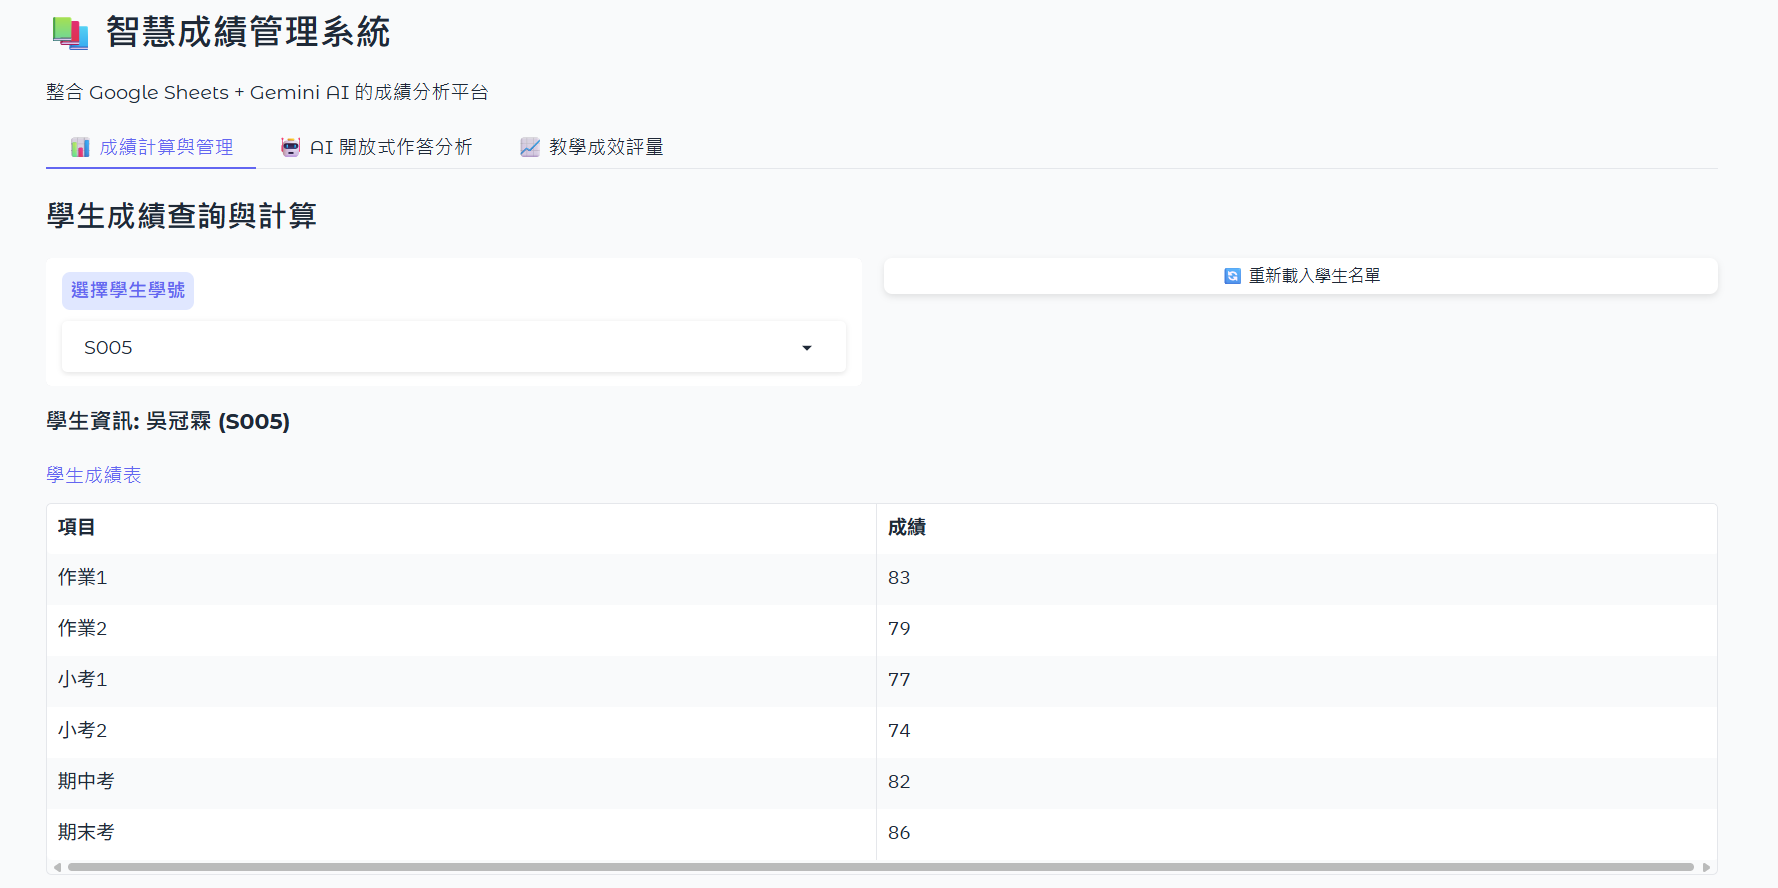

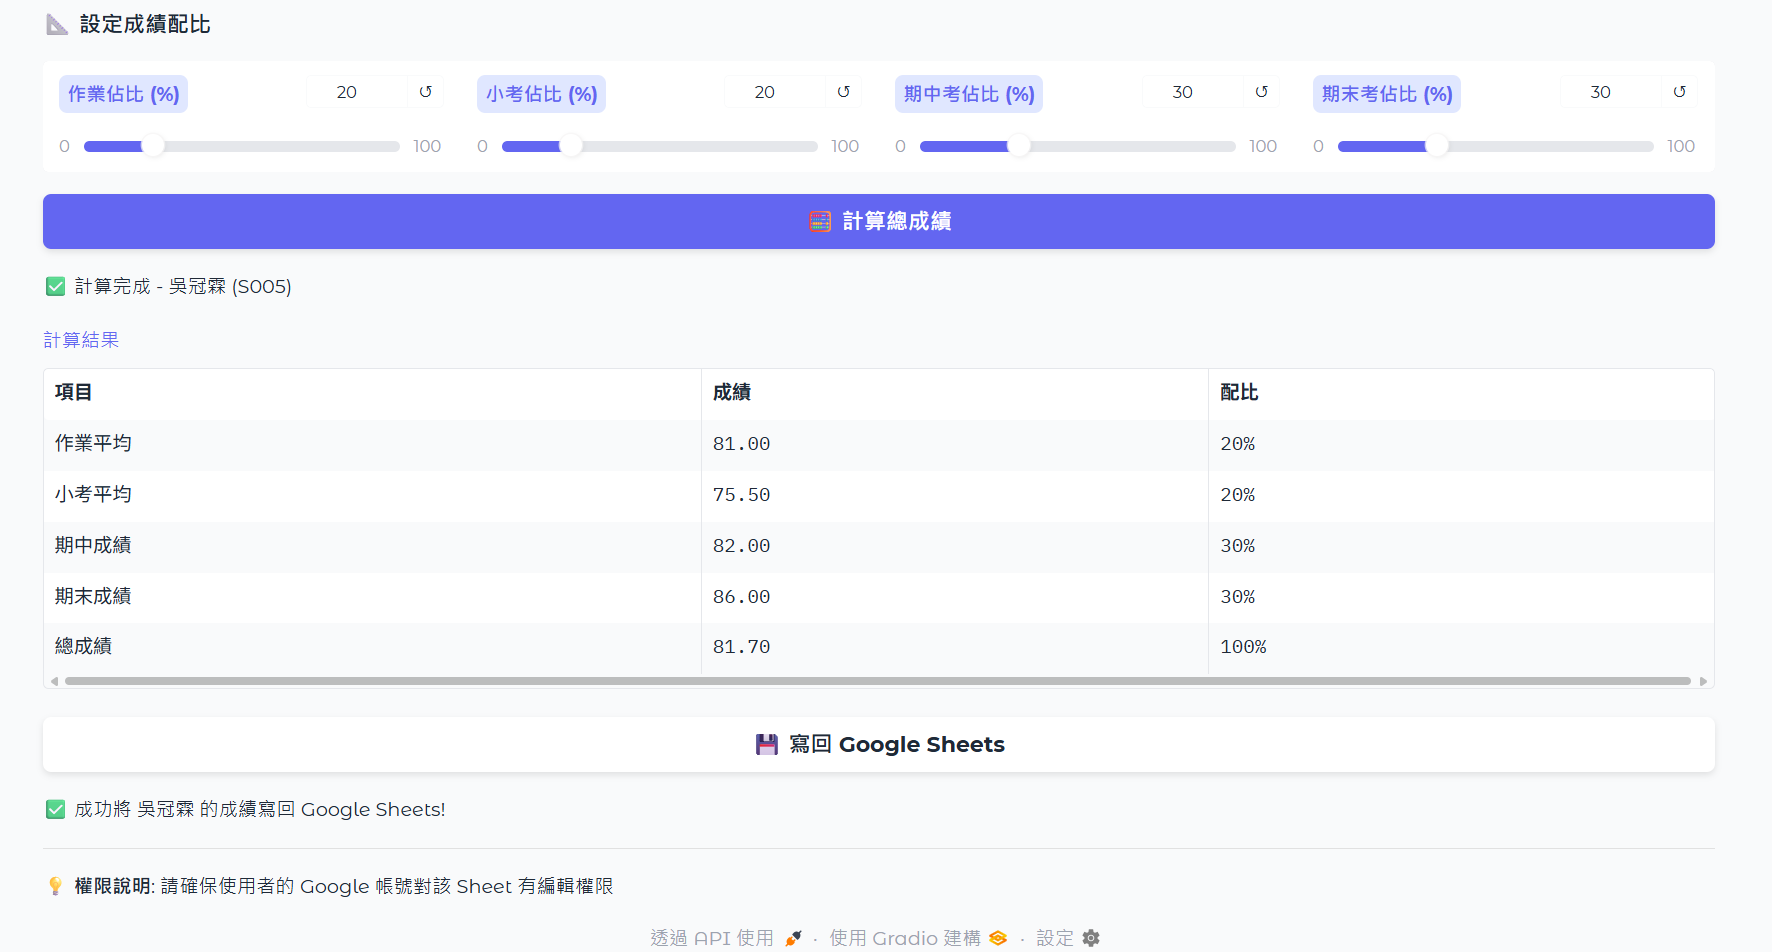

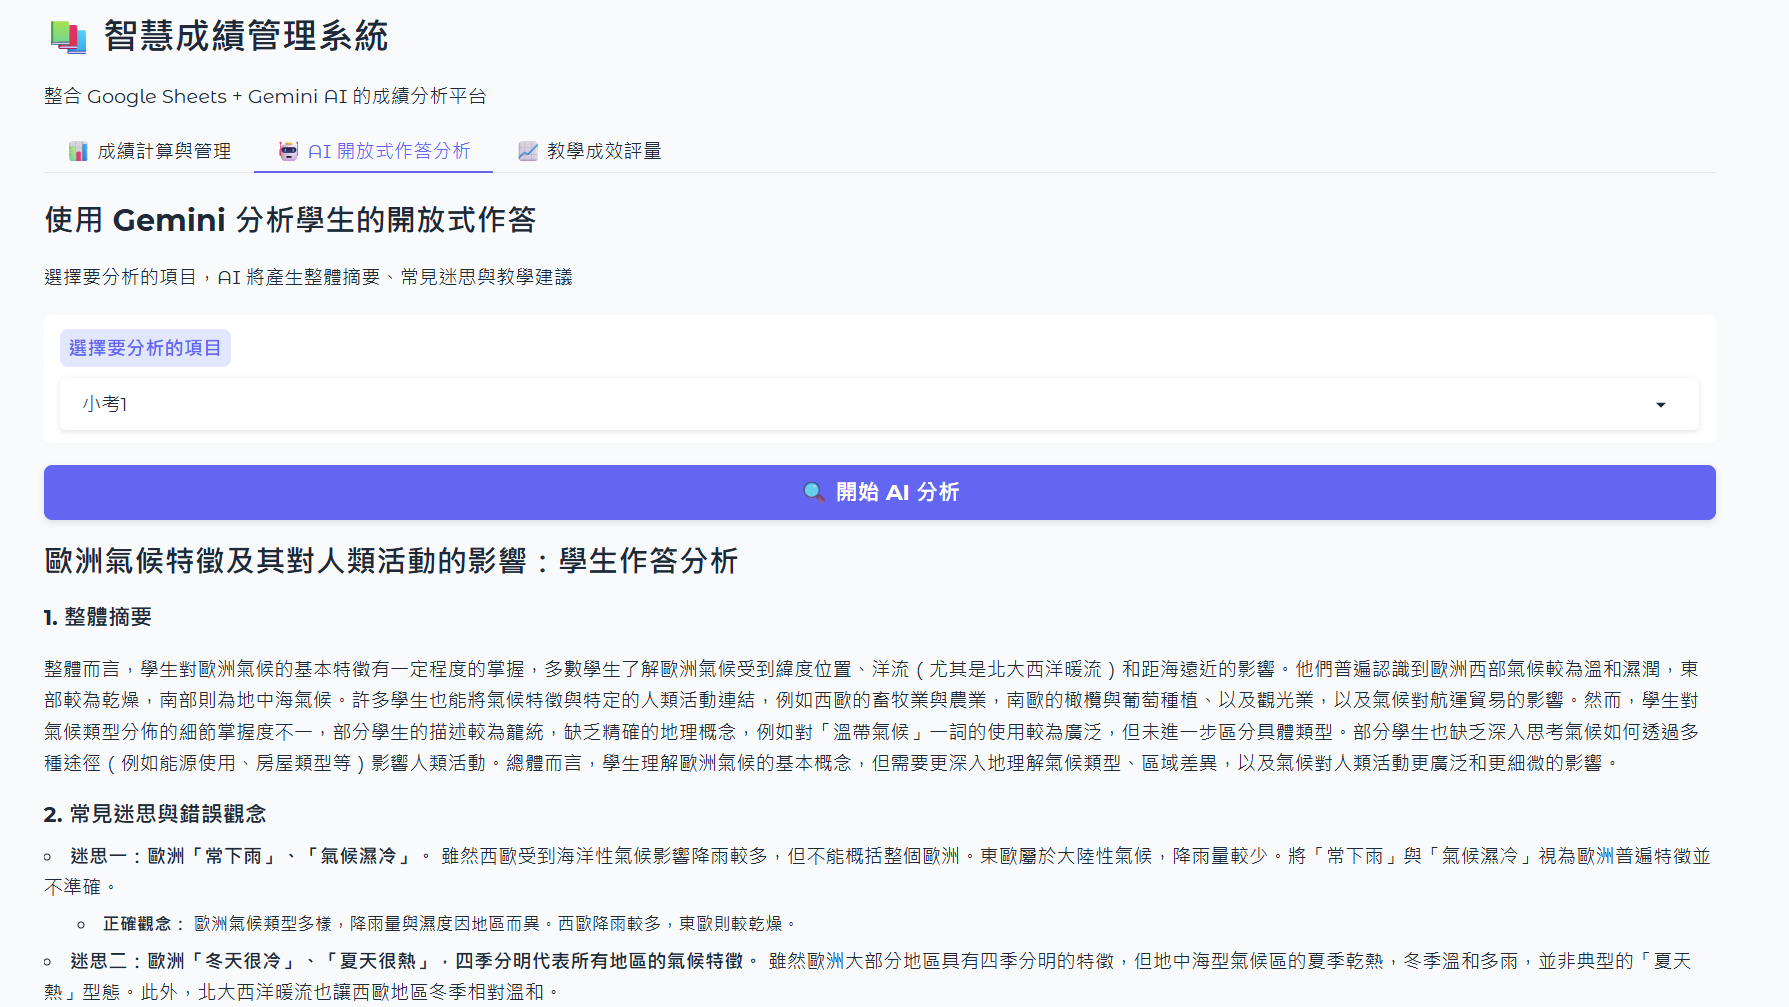

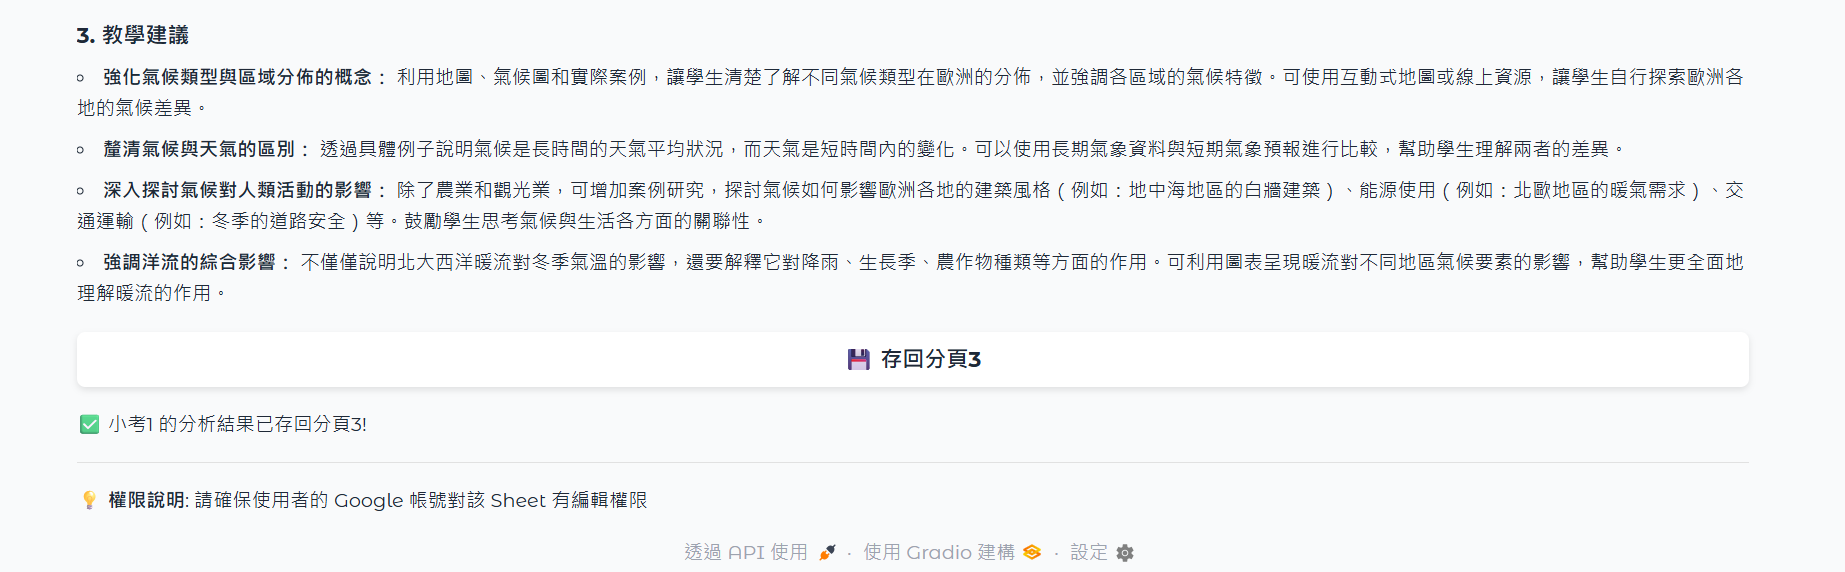

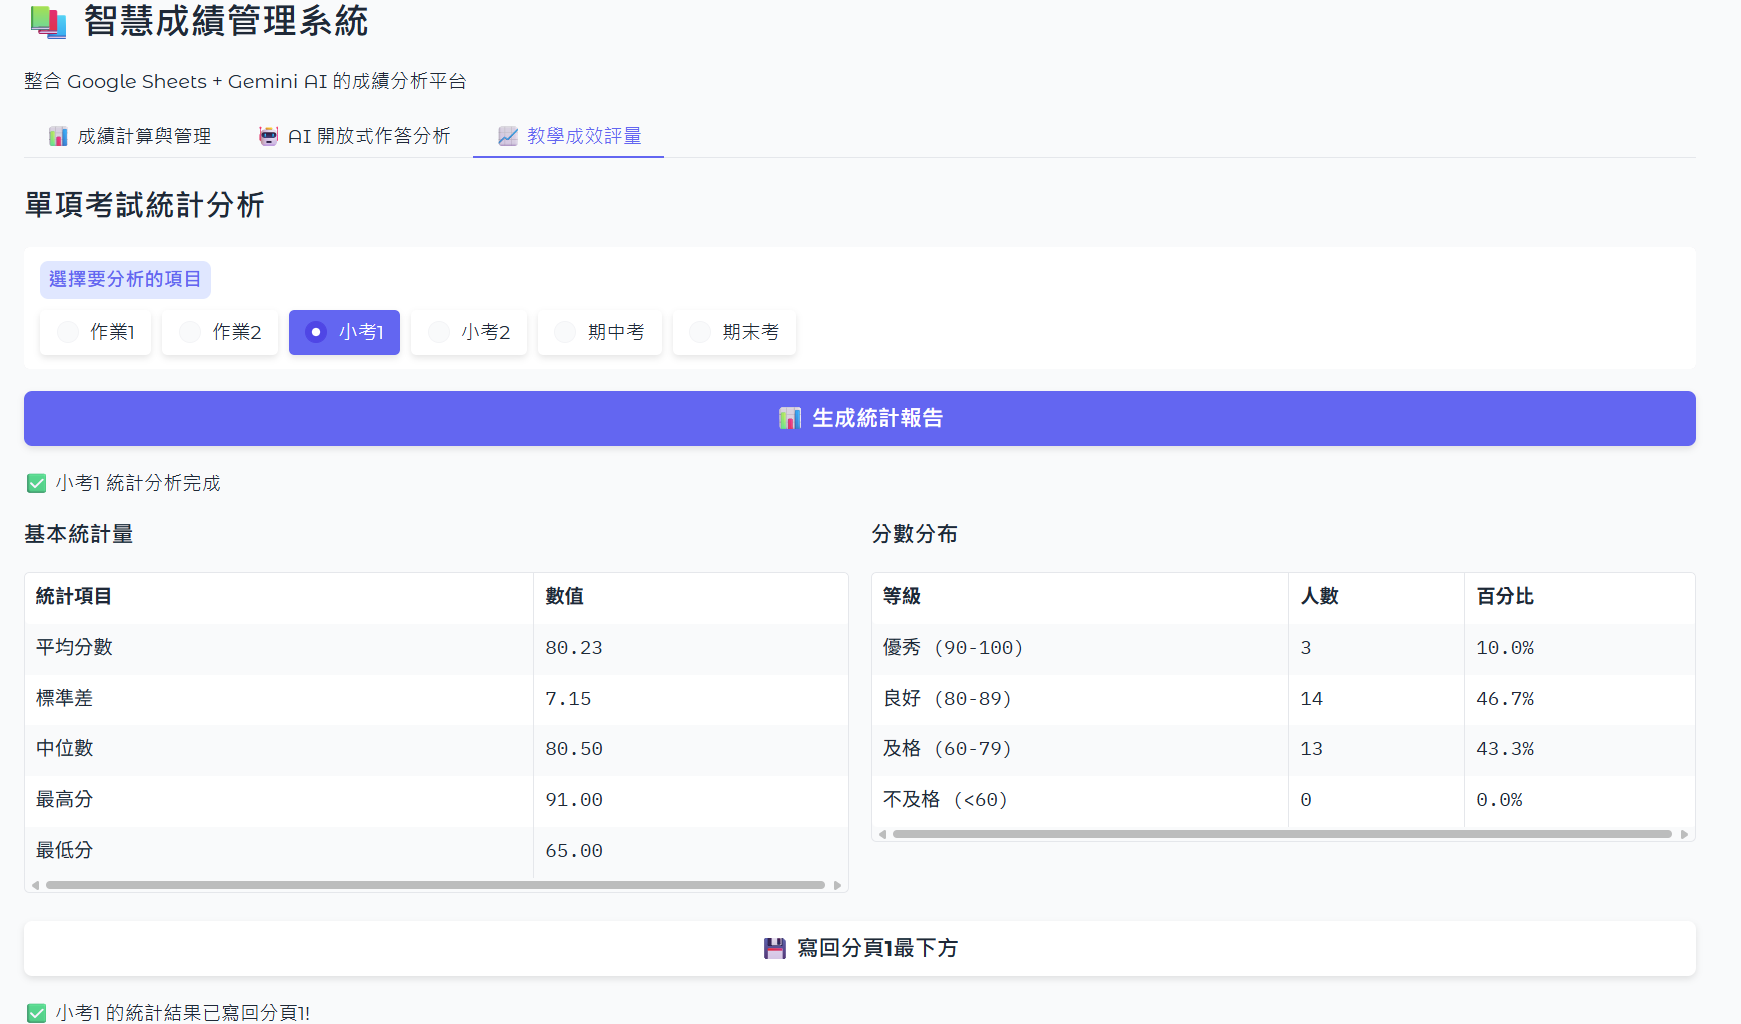